## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_El NINO_

In [3]:
data = pd.read_csv("datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


## Preprocessing the Data

In [4]:
# Multivariate data preparation
from numpy import array

# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[23.4 23.4 24.2 24.4 25.1 25.8 25.9 26.1 26.1 26.7] [26.1 26.1 25.7 25.6 25.1 25.3 25.1 24.6 24.2 24.3 23.7 23.4 23.2 22.8
 22.5 22.1 21.7 21.3 21.  20.2 20.6 20.4 20.4 19.8 20.2 19.7 20.1 20.3
 20.3 20.8 20.1 20.3 20.1 20.2 20.5 20.8 20.9 21.5 22.2 22.1 22.2 23.3
 23.2 23.5 23.7 24.2 24.7 25.4 26.  26.5 26.5 26.5]
[23.4 24.2 24.4 25.1 25.8 25.9 26.1 26.1 26.7 26.1] [26.1 25.7 25.6 25.1 25.3 25.1 24.6 24.2 24.3 23.7 23.4 23.2 22.8 22.5
 22.1 21.7 21.3 21.  20.2 20.6 20.4 20.4 19.8 20.2 19.7 20.1 20.3 20.3
 20.8 20.1 20.3 20.1 20.2 20.5 20.8 20.9 21.5 22.2 22.1 22.2 23.3 23.2
 23.5 23.7 24.2 24.7 25.4 26.  26.5 26.5 26.5 26.8]
[24.2 24.4 25.1 25.8 25.9 26.1 26.1 26.7 26.1 26.1] [25.7 25.6 25.1 25.3 25.1 24.6 24.2 24.3 23.7 23.4 23.2 22.8 22.5 22.1
 21.7 21.3 21.  20.2 20.6 20.4 20.4 19.8 20.2 19.7 20.1 20.3 20.3 20.8
 20.1 20.3 20.1 20.2 20.5 20.8 20.9 21.5 22.2 22.1 22.2 23.3 23.2 23.5
 23.7 24.2 24.7 25.4 26.  26.5 26.5 26.5 26.8 26.6]
[24.4 25.1 25.8 25.9 26.1 26.1 26.7 26.1 26.1 25.

## Train and Test Split

In [5]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1258, 1, 10) (1258, 52) (315, 1, 10) (315, 52)


## Model (Without Monte Carlo Dropout)

In [6]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 325
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(52))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
20/20 [==============================] - 3s 31ms/step - loss: 530.2357 - val_loss: 534.9893
Epoch 2/500
20/20 [==============================] - 0s 8ms/step - loss: 504.1124 - val_loss: 499.6827
Epoch 3/500
20/20 [==============================] - 0s 7ms/step - loss: 454.8049 - val_loss: 433.0084
Epoch 4/500
20/20 [==============================] - 0s 8ms/step - loss: 385.8316 - val_loss: 365.3442
Epoch 5/500
20/20 [==============================] - 0s 10ms/step - loss: 327.3999 - val_loss: 313.9291
Epoch 6/500
20/20 [==============================] - 0s 9ms/step - loss: 281.6727 - val_loss: 271.9510
Epoch 7/500
20/20 [==============================] - 0s 7ms/step - loss: 243.9042 - val_loss: 236.7353
Epoch 8/500
20/20 [==============================] - 0s 6ms/step - loss: 211.9023 - val_loss: 206.5093
Epoch 9/500
20/20 [==============================] - 0s 8ms/step - loss: 184.3026 - val_loss: 180.2195
Epoch 10/500
20/20 [==============================] - 0s 7ms/step - los

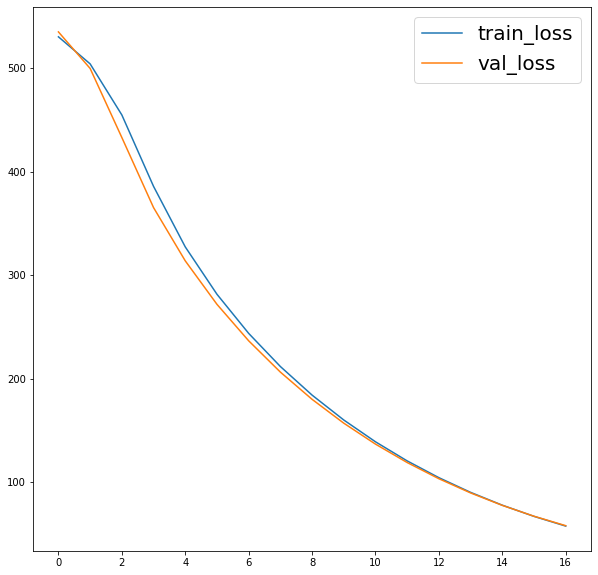

In [7]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (Without Monte Carlo Dropout)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_without_mc = testX
textY_without_mc = testY
yhat_without_mc = model.predict(textX_without_mc)
print(yhat_without_mc.shape)
textX_without_mc = textX_without_mc.reshape((textX_without_mc.shape[0], textX_without_mc.shape[2]*10))
print(textX_without_mc.shape)
inv_yhat_without_mc = np.concatenate((textX_without_mc, yhat_without_mc), axis=1)
inv_yhat1_without_mc = inv_yhat_without_mc[:, -3:]
inv_yhat_without_mc = inv_yhat_without_mc[:, -3]
inv_y_without_mc = np.concatenate((textX_without_mc, textY_without_mc), axis=1)
inv_y1_without_mc = inv_y_without_mc[:, -3:]
inv_y_without_mc = inv_y_without_mc[:, -3]
rmse_without_mc = np.sqrt(mean_squared_error(inv_y_without_mc, inv_yhat_without_mc))
mae_without_mc = mean_absolute_error(inv_y_without_mc, inv_yhat_without_mc)
print('Test RMSE: %.3f' % rmse_without_mc)
print('Test MAE: %.3f' % mae_without_mc)

11/11 [==============================] - 1s 2ms/step
(325, 52)
(325, 10)
Test RMSE: 7.522
Test MAE: 7.111


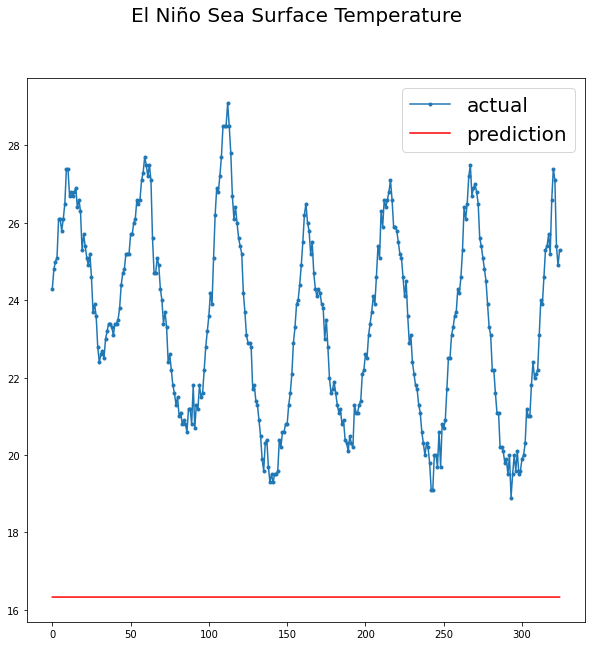

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_without_mc, marker='.', label="actual")
plt.plot(inv_yhat_without_mc, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model (With Monte Carlo Dropout)

In [10]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [11]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 325
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(52))
model.add(MCDropout(0.4))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
20/20 [==============================] - 3s 29ms/step - loss: 530.8196 - val_loss: 536.9700
Epoch 2/500
20/20 [==============================] - 0s 7ms/step - loss: 505.1779 - val_loss: 499.0334
Epoch 3/500
20/20 [==============================] - 0s 7ms/step - loss: 456.7987 - val_loss: 440.3438
Epoch 4/500
20/20 [==============================] - 0s 7ms/step - loss: 398.8734 - val_loss: 387.1415
Epoch 5/500
20/20 [==============================] - 0s 7ms/step - loss: 352.1689 - val_loss: 346.5670
Epoch 6/500
20/20 [==============================] - 0s 7ms/step - loss: 319.5669 - val_loss: 317.4397
Epoch 7/500
20/20 [==============================] - 0s 7ms/step - loss: 292.0347 - val_loss: 292.1509
Epoch 8/500
20/20 [==============================] - 0s 7ms/step - loss: 275.2705 - val_loss: 274.5845
Epoch 9/500
20/20 [==============================] - 0s 7ms/step - loss: 258.5454 - val_loss: 259.6671
Epoch 10/500
20/20 [==============================] - 0s 8ms/step - loss

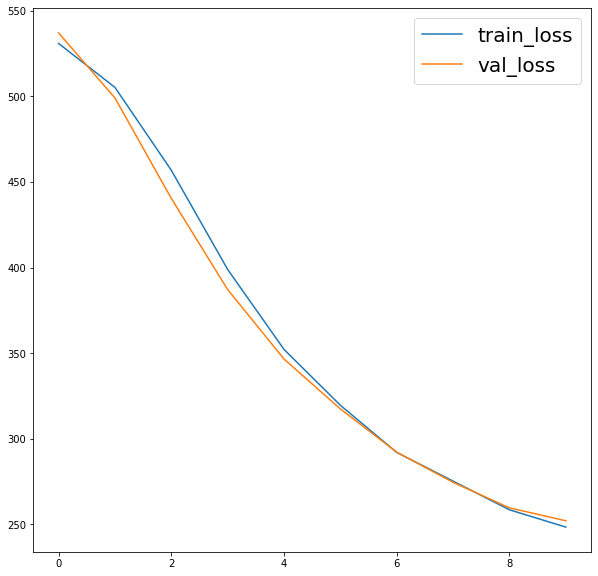

In [12]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (With Monte Carlo Dropout)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_with_mc = testX
textY_with_mc = testY
yhat_with_mc = model.predict(textX_with_mc)
print(yhat_with_mc.shape)
textX_with_mc = testX.reshape((textX_with_mc.shape[0], textX_with_mc.shape[2]*10))
print(textX_with_mc.shape)
inv_yhat_with_mc = np.concatenate((textX_with_mc, yhat_with_mc), axis=1)
inv_yhat1_with_mc = inv_yhat_with_mc[:, -3:]
inv_yhat_with_mc = inv_yhat_with_mc[:, -3]
inv_y_with_mc = np.concatenate((textX_with_mc, textY_with_mc), axis=1)
inv_y1_with_mc = inv_y_with_mc[:, -3:]
inv_y_with_mc = inv_y_with_mc[:, -3]
rmse_with_mc = np.sqrt(mean_squared_error(inv_y_with_mc, inv_yhat_with_mc))
mae_with_mc = mean_absolute_error(inv_y_with_mc, inv_yhat_with_mc)
print('Test RMSE: %.3f' % rmse_with_mc)
print('Test MAE: %.3f' % mae_with_mc)

11/11 [==============================] - 0s 2ms/step
(325, 52)
(325, 10)
Test RMSE: 15.866
Test MAE: 13.030


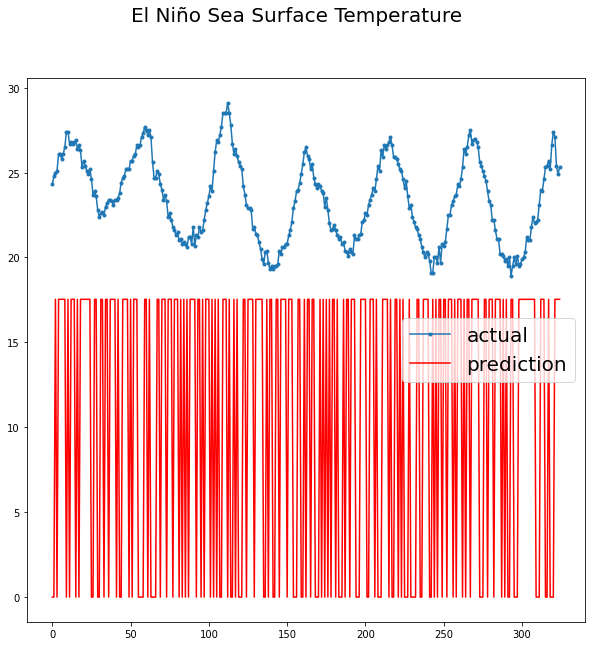

In [14]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_with_mc, marker='.', label="actual")
plt.plot(inv_yhat_with_mc, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()